In [1]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

In [2]:
# https://pvsc-python-tutorials.github.io/PVSC48-Python-Tutorial/Tutorial%20A%20-%20Single%20Diode%20Model.html

In [3]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, metadata = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)

location = pvlib.location.Location(latitude=metadata['latitude'],
                                   longitude=metadata['longitude'])

times = df_tmy.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
solar_position.index += pd.Timedelta('30min')

tracker_data = pvlib.tracking.singleaxis(solar_position['apparent_zenith'],
                                         solar_position['azimuth'],
                                         axis_azimuth=180,
                                         )
tilt = tracker_data['surface_tilt'].fillna(0)
azimuth = tracker_data['surface_azimuth'].fillna(0)

df_poa_tracker = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt,
                                                       surface_azimuth=azimuth,
                                                       dni=df_tmy['DNI'],
                                                       ghi=df_tmy['GHI'],
                                                       dhi=df_tmy['DHI'],
                                                       solar_zenith=solar_position['apparent_zenith'],
                                                       solar_azimuth=solar_position['azimuth'])
tracker_poa = df_poa_tracker['poa_global']

parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']
cell_temperature = pvlib.temperature.sapm_cell(tracker_poa,
                                               df_tmy['DryBulb'],
                                               df_tmy['Wspd'],
                                               **parameters)

C:\Users\quean\anaconda3\lib\site-packages\pvlib\iotools\tmy.py:247: pvlibDeprecationWarning: TMY3 variable names will be renamed to pvlib conventions by default starting in pvlib 0.11.0. Specify map_variables=True to enable that behavior now, or specify map_variables=False to hide this warning.
  warnings.warn(


In [4]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 1e3

array_power = pvlib.pvsystem.pvwatts_dc(tracker_poa, cell_temperature, nameplate, gamma_pdc)

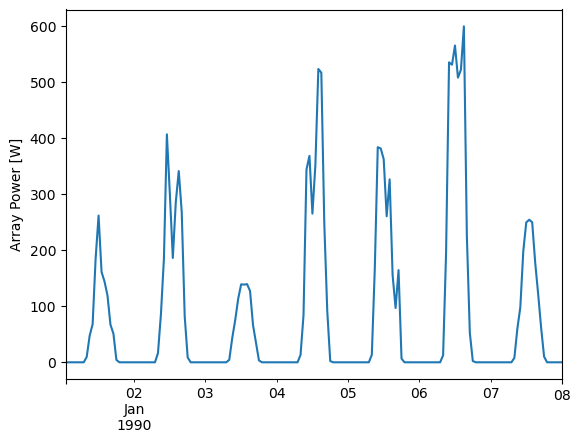

In [5]:
array_power.head(24*7).plot()
plt.ylabel('Array Power [W]');

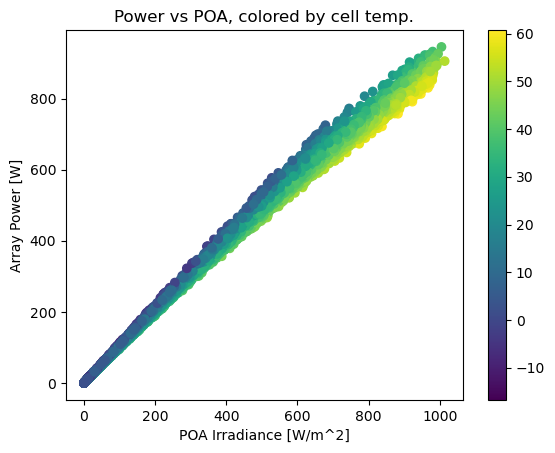

In [6]:
plt.scatter(tracker_poa, array_power, c=cell_temperature)
plt.colorbar()
plt.ylabel('Array Power [W]')
plt.xlabel('POA Irradiance [W/m^2]')
plt.title('Power vs POA, colored by cell temp.');

Text(0, 0.5, 'Energy [Wh]')

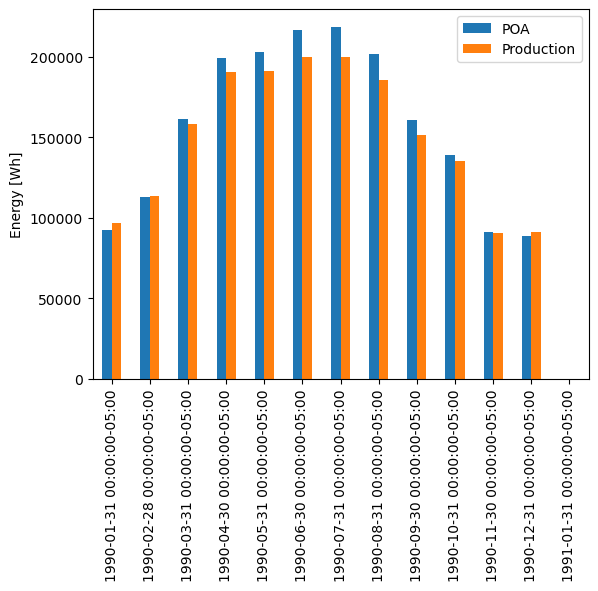

In [7]:
df_plot = pd.DataFrame({
    'POA': tracker_poa,
    'Production': array_power,
})
# summing hourly power (W) gives (W h)
df_plot.resample('M').sum().plot.bar()
plt.ylabel('Energy [Wh]')

In [8]:
pdc0 = 800/0.96  # W
ac = pvlib.inverter.pvwatts(array_power, pdc0)

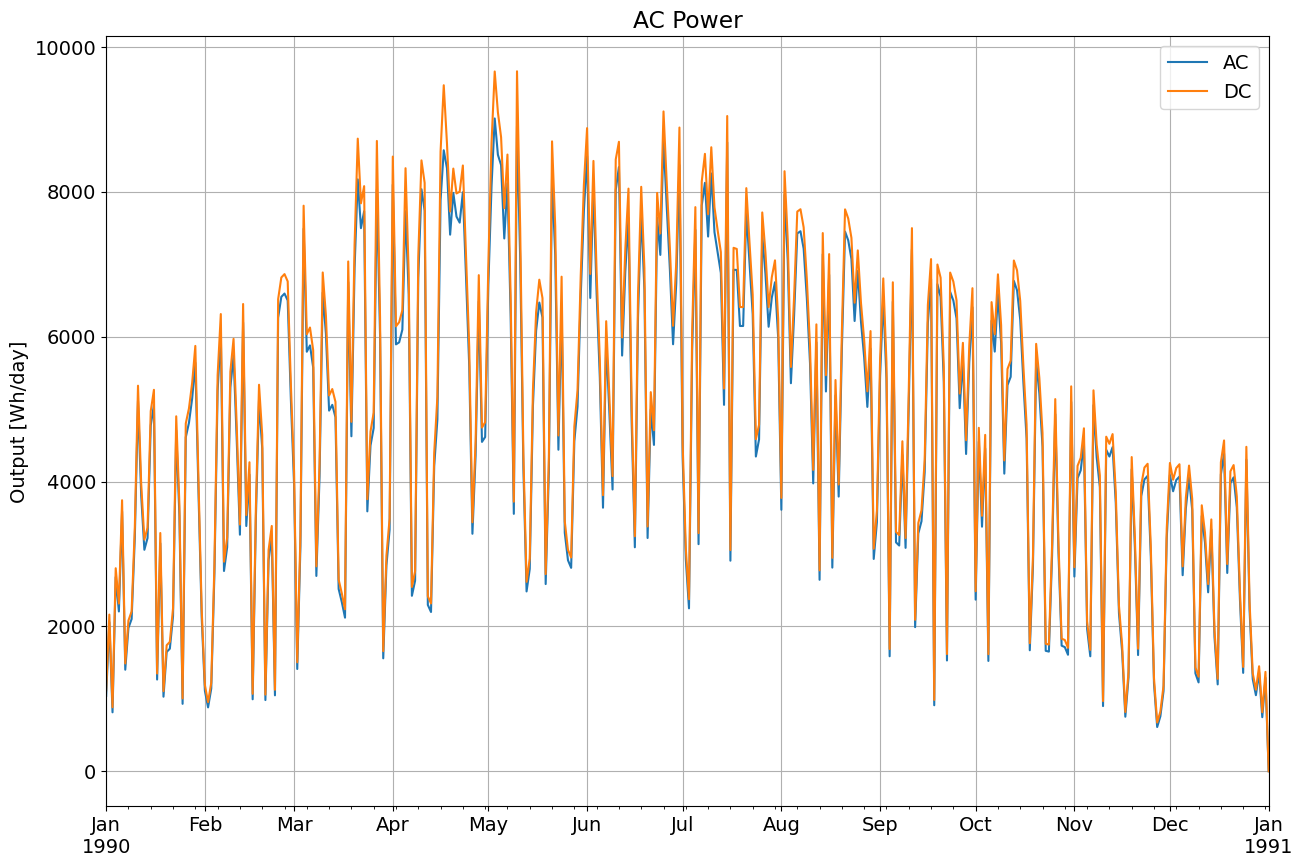

In [9]:
plt.rcParams['font.size'] = 14
ax = ac.resample('D').sum().plot(figsize=(15, 10), label='AC')
array_power.resample('D').sum().plot(ax=ax, label='DC')
plt.title('AC Power')
plt.ylabel('Output [Wh/day]')
plt.grid()
plt.legend()